<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='#FFFFFFF'> <center>
Proyecto 4</center></font></h1>
<h2><font color='#FFFFFFF'> <center>
Proyecto 2024-02 </center></font></h2>
<h3><font color='#FFFFFFF'> <center>María J. Ostos - Cristian Florez - Juan A. Sañudo</center></font></h3>
<h3><font color='#FFFFFFF'> <center>
2024 </center></font></h3>
<font  face="Courier New" size="3">
<p1><center> </center></p1>

1. Revisión teórica. Del artículo:
https://www.nature.com/articles/s41598-020-59821-7

Hacer un resumen de la sección extracción de caracteríticas (Features extraction) y discutir desde el artículo u otras referencias como se hace cuando desaparecen ciertas formas de ondas en el complejo PQRS debido a alguna enfermedad (10%)

2. Base de datos. Del proyecto pasado hay dos opciones de base de datos, la filtrada por los autores o la filtrada en el proyecto 3. De acuerdo a los resultados del proyecto 3 usar la mejor base de datos y justificar la selección
De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

### Carga de librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
# from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import detrend, welch, butter, filtfilt
# from scipy.signal import welch
# from numpy.polynomial.polynomial import Polynomial
# import os
import pywt
# from scipy import stats
import random
# from scipy.stats import shapiro, levene, mannwhitneyu
# import seaborn as sns


### Carga de datos Diagnostics.xlsx

In [2]:
fs=500

# ruta_diagnostics= r"C:\Users\Lenovo a9 w10\Documents\LabBiosenales\Proyecto_2/Diagnostics.xlsx"
ruta_diagnostics="../Proyecto_3/datos/Diagnostics.xlsx"
df_diagnostics = pd.read_excel(ruta_diagnostics)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos_diagnostics = df_diagnostics[(df_diagnostics['Rhythm'] == 'SB') | (df_diagnostics['Rhythm'] == 'AFIB')]

#Tamaño del nuevo dataframe
datos_diagnostics.shape

tiempo_diagnostics = np.arange(0, datos_diagnostics.shape[0]/fs,1/fs)

datos_diagnostics.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [3]:
# Separar nombres de archivo en listas según el ritmo 'SB' y 'AFIB'
sb_files = datos_diagnostics[datos_diagnostics['Rhythm'] == 'SB']['FileName'].tolist()
afib_files = datos_diagnostics[datos_diagnostics['Rhythm'] == 'AFIB']['FileName'].tolist()

In [4]:
# Número total de archivos a seleccionar
n_seleccion = 5

# Calcular la mitad para cada ritmo (o una distribución casi mitad y mitad si n_seleccion es impar)
n_sb = n_seleccion // 2
n_afib = n_seleccion - n_sb

# Seleccionar aleatoriamente el número calculado de archivos de cada tipo
selected_sb_files = random.sample(sb_files, min(n_sb, len(sb_files)))
selected_afib_files = random.sample(afib_files, min(n_afib, len(afib_files)))

# Combinar las selecciones de 'SB' y 'AFIB' en la lista final
selected_files = selected_sb_files + selected_afib_files

# Mezclar los archivos seleccionados para no tener un orden específico de 'SB' o 'AFIB'
random.shuffle(selected_files)
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data = datos_diagnostics[datos_diagnostics['FileName'].isin(selected_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_dict = dict(zip(selected_data['FileName'], selected_data['Rhythm']))

In [5]:
def filtro_wavelet(signal_data, wavelet='db4', nivel=4):
    coeffs = pywt.wavedec(signal_data, wavelet, level=nivel)
    umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs,wavelet)



In [6]:
def cargar_datos(selected_files,ruta): #Ruta 1 sin filtrar, 2 para filtrados
    # Diccionario para almacenar cada DataFrame y su columna 'II'
    data_frames = {}
    datos_II = {}
    
    # Iterar sobre los archivos en la lista
    for i, file in enumerate(selected_files):
        if ruta==1:
            df = pd.read_csv(f"../Proyecto_3/datos/ECGData/ECGData/{file}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        elif ruta==2:
            df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{file}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        data_frames[f"df{i+1}"] = df
        # datos_II[f"datos_f{i+1}"] = df["II"]
        datos_II[f"{file}"] = df["II"]
    
    return data_frames, datos_II


In [30]:
# Flujo 1: Filtro pasa-altas, Filtro wavelet, Filtro pasabajas
def flujo_1(data,fs = 1000 ):
    # Paso 1: Filtro pasa-altas IIR a 0.5 Hz
    cutoff = 0.5  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='highpass', fs=fs, output='sos')
    data_highpass = signal.sosfilt(sos, data)
    
    # Paso 2: Filtro wavelet
    data_denoised=filtro_wavelet(data_highpass, wavelet='db4', nivel=4)
    
    # Paso 3: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_denoised)
    
    return data_lowpass

# Flujo 2: Detrend, Filtro wavelet, Filtro pasabajas
def flujo_2(data,fs = 1000 ):
    # Paso 1: Detrend
    data_detrended = signal.detrend(data)
    
    # Paso 2: Filtro wavelet
    data_denoised=filtro_wavelet(data_detrended, wavelet='db4', nivel=4)

    # Paso 3: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_denoised)
    
    return data_lowpass

# Flujo 3: Filtro pasa-altas, Filtro pasabajas
def flujo_3(data,fs = 1000 ):
    # Paso 1: Filtro pasa-altas IIR a 0.5 Hz
    cutoff = 0.5  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='highpass', fs=fs, output='sos')
    data_highpass = signal.sosfilt(sos, data)
    

    # Paso 2: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_highpass)
    
    return data_lowpass







def flujo_2_ajustado(data,fs = 1000 ):
    cutoff= 0.5  # Frecuencia de corte en Hz
    order=4
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    data_f=filtfilt(b, a, data)
    
    # Paso 1: Detrend    
    data_detrended = signal.detrend(data_f)
    
    # Paso 2: Filtro wavelet
    data_denoised=filtro_wavelet(data_detrended, wavelet='db4', nivel=4)

    # Paso 3: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_denoised)
    
    return data_lowpass

In [8]:
def detrend_n_deviation(data,tiempo):
    datos_detrend=signal.detrend(data)
    datos_deviation=np.mean((data-datos_detrend)**2)
    return datos_detrend, datos_deviation

def compress(signal):
    xmin, xmax = np.min(signal), np.max(signal)
    if xmin == xmax:
        return signal  # Evitar dividir por cero si no hay rango
    compressed_signal = (signal - xmin) / (xmax - xmin)
    return np.array(compressed_signal)

# Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela 
def obtener_frecuencia_maxima_potencia(df, fs=1000):
    nperseg = 1024 
    noverlap = int(nperseg / 2)  
    ventana = np.hamming(nperseg)  
    
    # Calcular la densidad espectral de potencia utilizando Welch
    frecuencias, potencia = welch(df, fs=fs,window=ventana, nperseg=nperseg, noverlap=noverlap)

    # Encontrar la frecuencia con la máxima potencia
    indice_max_potencia = potencia.argmax()
    frecuencia_max = frecuencias[indice_max_potencia]

    return frecuencia_max


In [9]:
dfs1,datos_II_1=cargar_datos(selected_files,1)
sujetos=datos_II_1.keys()
dfs2,datos_II_2=cargar_datos(selected_files,2)

In [15]:
sujetos

dict_keys(['MUSE_20180116_171851_18000', 'MUSE_20180113_072102_95000', 'MUSE_20180116_130935_93000', 'MUSE_20180712_155838_47000', 'MUSE_20180112_124429_51000'])

MUSE_20180116_171851_18000


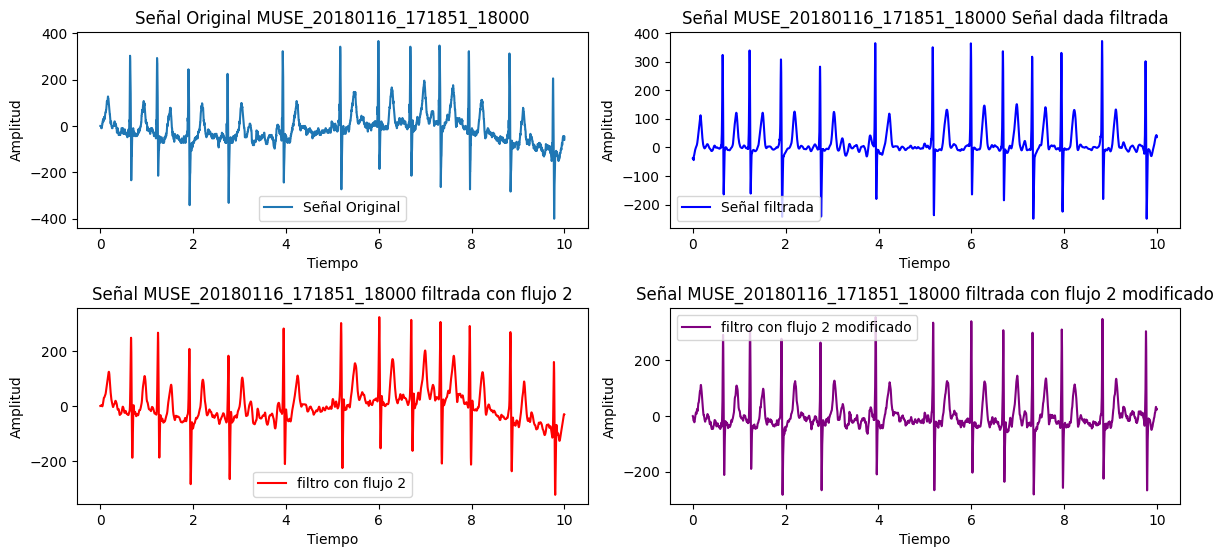

MUSE_20180113_072102_95000


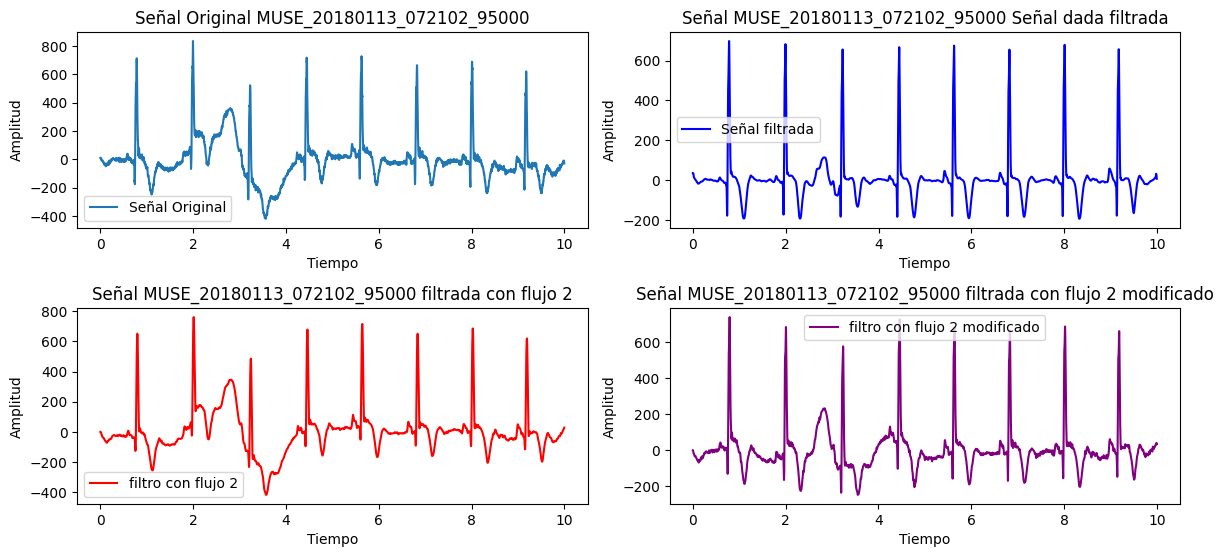

MUSE_20180116_130935_93000


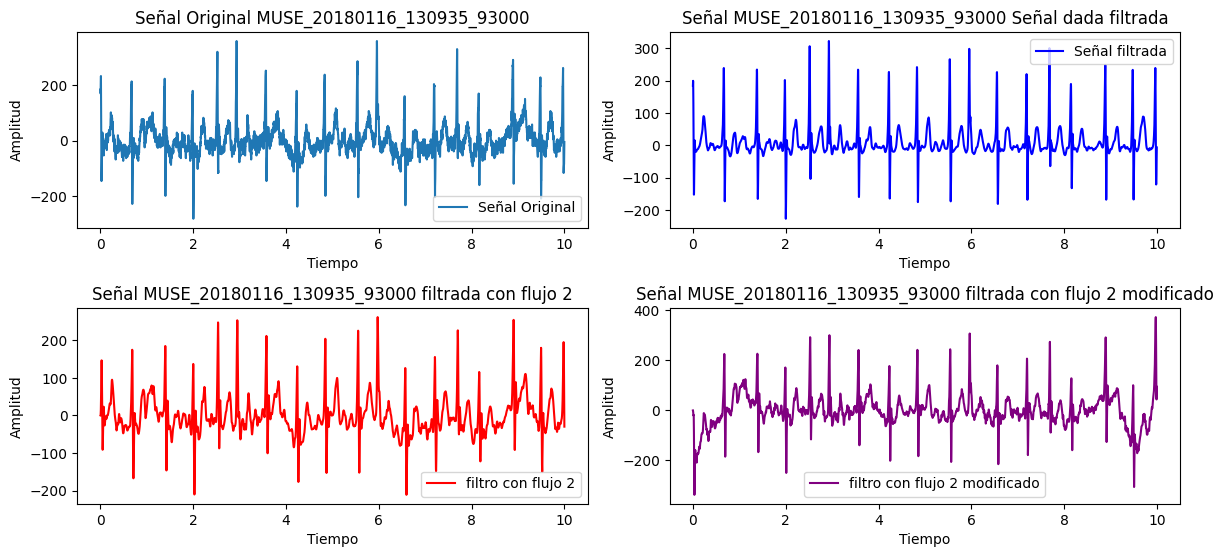

MUSE_20180712_155838_47000


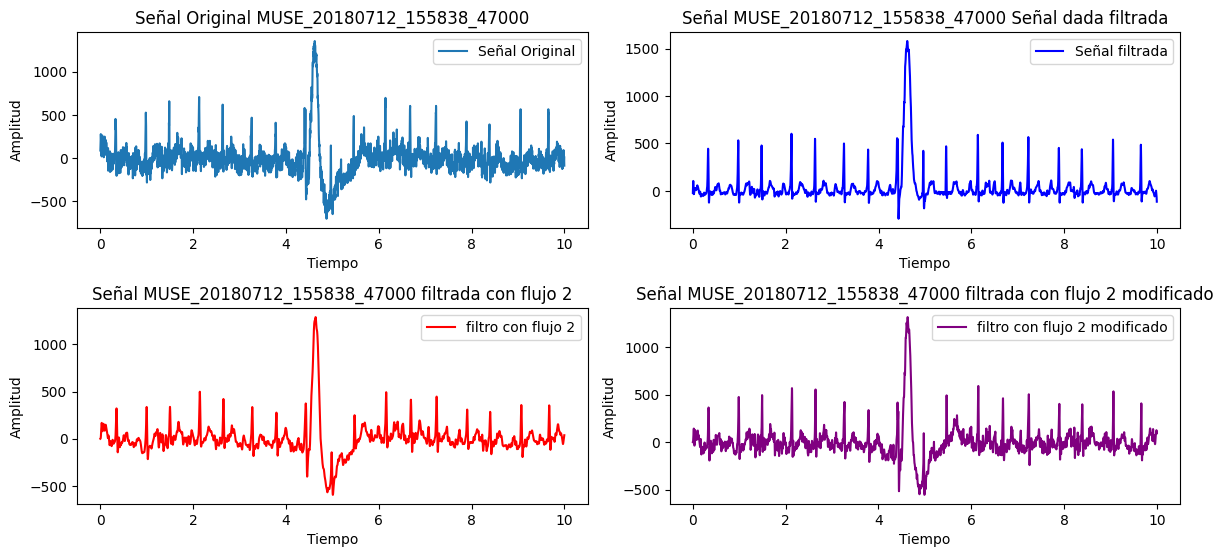

MUSE_20180112_124429_51000


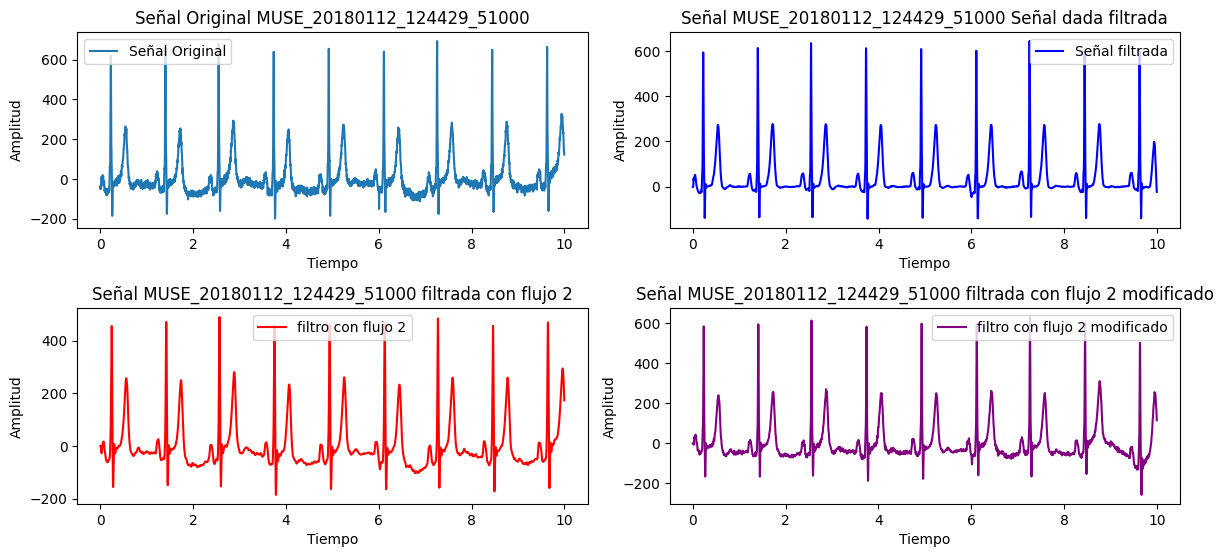

In [32]:
#Aplicación de flujos

for archivo in sujetos:
    print(archivo)
    original=datos_II_1[archivo][1:].astype(float)  # Convertir a tipo numérico si es necesario
    
    filtrada=datos_II_2[archivo][1:].astype(float)  # Convertir a tipo numérico si es necesario
    

    flujo2=flujo_2(original)
    flujo_ajust=flujo_2_ajustado(original,fs)

    
    tiempo_1= np.arange(0, original.shape[0]/fs,1/fs)
    tiempo_2= np.arange(0, filtrada.shape[0]/fs,1/fs)

    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 2, 1)
    plt.plot(tiempo_1,original, label='Señal Original')
    plt.title(f'Señal Original {archivo}')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()
    
    plt.subplot(3, 2, 2)
    plt.plot(tiempo_2,filtrada, label='Señal filtrada', color='blue')
    plt.title(f'Señal {archivo} Señal dada filtrada')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.plot(tiempo_1,flujo2, label='filtro con flujo 2', color="red")
    plt.title(f'Señal {archivo} filtrada con flujo 2')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(tiempo_1,flujo_ajust, label='filtro con flujo 2 modificado', color='purple')
    plt.title(f'Señal {archivo} filtrada con flujo 2 modificado')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
#Aplicación de flujos

for archivo in sujetos:
    print(archivo)
    data=datos_II_1[archivo][1:].astype(float)  # Convertir a tipo numérico si es necesario
    proc_signal_1=flujo_1(data)
    proc_signal_2=flujo_2(data)
    proc_signal_3=flujo_3(data)
    tiempo = np.arange(0, data.shape[0]/fs,1/fs)


    # Graficar señal prefiltrada, señal original y señal procesada
    # plt.figure()
    plt.figure(figsize=(12, 8))


    plt.subplot(2, 2, 1)
    plt.plot(tiempo,data, label='Señal Original')
    plt.title(f'Señal Original {archivo}')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()


    plt.subplot(2, 2, 2)
    plt.plot(tiempo,proc_signal_1, label='Flujo 1', color="red")
    plt.title(f'Señal {archivo} con flujo 1')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()


    plt.subplot(2, 2, 3)
    plt.plot(tiempo,proc_signal_2, label='Flujo 2', color='purple')
    plt.title(f'Señal {archivo} con flujo 2')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(tiempo,proc_signal_3, label='Flujo 3', color="black")
    plt.title(f'Señal {archivo} con flujo 3')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Para todos los datos

In [49]:
all_files = datos_diagnostics['FileName'].tolist()

In [50]:
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data_all = datos_diagnostics[datos_diagnostics['FileName'].isin(all_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_all = dict(zip(selected_data_all['FileName'], selected_data_all['Rhythm']))

## Procesado con flujo 2

In [51]:
# Crear un DataFrame vacío para almacenar los resultados
df_resultados_flujo = pd.DataFrame(columns=["Registro", "Estado", "fMP"])

for archivo in all_files:
    # Leer el archivo CSV
    # df = pd.read_csv(fr"C:\Users\Lenovo a9 w10\Downloads\Proyecto3\ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    datos_II=df["II"]
    tiempo = np.arange(0, datos_II.shape[0]/fs,1/fs)

# Obtener el nombre del sujeto (sin extensión .csv)
    nombre_sujeto = archivo[:-4] #Registro

# Procesar los archivos
    data_detrended1=detrend_n_deviation(datos_II,tiempo)
    data_compressed=compress(data_detrended1[0])
    data_detrended=detrend_n_deviation(data_compressed,tiempo)
    resultados_proceso=flujo_2(data_detrended[0],fs)

    estado = file_rhythm_all[archivo] #Estado
    
    F_max=obtener_frecuencia_maxima_potencia(resultados_proceso,fs)
    # F_max=resultados_proceso[3] #fMP
    
    df_resultados_flujo = pd.concat([df_resultados_flujo,
                    pd.DataFrame({'Registro': nombre_sujeto,
                                    'Estado': estado,
                                    'fMP': F_max},
                                index=[0])
                    ],
                    ignore_index=True)

C:\Users\crist\AppData\Local\Temp\ipykernel_888\4047622354.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados_flujo = pd.concat([df_resultados_flujo,


In [52]:
df_resultados_flujo

,Registro,Estado,fMP
0,MUSE_20180113_171327_2,AFIB,13.183594
1,MUSE_20180112_073319_2,SB,3.417969
2,MUSE_20180113_121940_4,SB,3.417969
3,MUSE_20180112_120347_7,SB,3.906250
4,MUSE_20180114_075026_6,AFIB,4.394531
...,...,...,...
5664,MUSE_20180114_134724_1,SB,2.929688
5665,MUSE_20180113_122544_2,SB,0.976562
5666,MUSE_20180114_074720_8,SB,11.230469
5667,MUSE_20180115_131524_9,AFIB,1.464844


In [ ]:
# df_resultados_flujo.to_excel("Dataframe_P3.xlsx", index=False)

Prueba de Normalidad

Hipótesis nula (Ho): Las frecuencias de Máxima potencia de las señales prefiltradas en el proyecto 2/3 no distribuyen normal. 

Hipótesis alternativa (H1): Las frecuencias de Máxima potencia de las señales prefiltradas en el proyecto 2/3 distribuyen normal. 

In [ ]:
# Prueba de Shapiro-Wilk para normalidad
stat1, p_value1 = shapiro(fmp1)
stat2, p_value2 = shapiro(fmp2)

# print("Prueba de normalidad para fMP del primer dataframe:")
# print(f"Estadístico: {stat1}, p-valor: {p_value1}")

# print("Prueba de normalidad para fMP del segundo dataframe:")
# print(f"Estadístico: {stat2}, p-valor: {p_value2}")

# Interpretación
if p_value1 > alpha:
    print(f"El dataframe con procesamiento del proyecto 2 sigue una distribución normal con valor-p: {p_value1}.")
else:
    print(f"El dataframe con procesamiento del proyecto 2 no sigue una distribución normal con valor-p: {p_value1}.")

if p_value2 > alpha:
    print(f"El dataframe con procesamiento con el flujo 2 sigue una distribución normal con valor-p: {p_value2}.")
else:
    print(f"El dataframe con procesamiento con el flujo 2 no sigue una distribución normal con valor-p: {p_value2}.")


Prueba Homocedasticidad  

Hipótesis nula (Ho): Las varianzas de las frecuencias de Maxima Potencia no son significativamente diferentes entre los dos proyectos (2 y 3).

Hipótesis alternativa (H1): Las varianzas de las frecuencias de Maxima Potencia son significativamente diferentes entre los dos proyectos (2 y 3)

In [ ]:
# Prueba de Levene para homocedasticidad
stat, p_value_h = levene(fmp1, fmp2)

# print("Prueba de homocedasticidad (Levene):")
# print(f"Estadístico: {stat}, p-valor: {p_value}")

# Interpretación
if p_value_h > alpha:
    print(f"Las varianzas son homogéneas (se cumple homocedasticidad) con valor-p: {p_value_h}.")
else:
    print(f"Las varianzas no son homogéneas (no se cumple homocedasticidad) con valor-p: {p_value_h}.")


In [ ]:
stat, p_value_m = mannwhitneyu(fmp1, fmp2, alternative='two-sided')
# print("\nPrueba de Mann-Whitney U:")
# print(f"Estadístico: {stat}, p-valor: {p_value}")
if p_value_m < alpha:
    print(f"Existen diferencias significativas entre ambos dataframes con valor-p: {p_value_m}.")
else:
    print(f"No existen diferencias significativas entre ambos dataframes con valor-p: {p_value_m}.")


In [ ]:
print("Primer dataframe:")
print(fmp1.describe())
print("Segundo dataframe:")
print(fmp2.describe())


In [ ]:
# Histograma de cada conjunto de datos
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.histplot(fmp1, kde=True)
plt.title('Distribución de fMP en el primer dataframe')

plt.subplot(1, 2, 2)
sns.histplot(fmp2, kde=True)
plt.title('Distribución de fMP en el segundo dataframe')
plt.show()

# Gráfico Q-Q para normalidad
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(fmp1, dist="norm", plot=plt)
plt.title('Q-Q plot para fMP del primer dataframe')

plt.subplot(1, 2, 2)
stats.probplot(fmp2, dist="norm", plot=plt)
plt.title('Q-Q plot para fMP del segundo dataframe')
plt.show()


In [ ]:
# Crear un dataframe combinado
df_combined = pd.DataFrame({
    'fMP': pd.concat([fmp1, fmp2]),
    'Dataset': ['Dataframe 1'] * len(fmp1) + ['Dataframe 2'] * len(fmp2)
})

# Boxplot con Pandas
df_combined.boxplot(by='Dataset', column='fMP', grid=False, figsize=(10, 5))
plt.title('Boxplot con Pandas')
plt.suptitle('')
plt.ylabel('fMP')
plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_combined, x='Dataset', y='fMP')
plt.title('Violin Plot con Seaborn y Dataframe combinado')
plt.show()


# Referencias

[1] 